# Changing Ambient Temperature for Low C-rate Simulations

In [5]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"

# %matplotlib widget

In [6]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [7]:
parameter_values.search("SEI")

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Inner SEI electron conductivity [S.m-1]	8.95e-14
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Inner SEI open-circuit potential [V]	0.1
Inner SEI partial molar volume [m3.mol-1]	9.585e-05
Inner SEI reaction proportion	0.5
Outer SEI open-circuit potential [V]	0.8
Outer SEI partial molar volume [m3.mol-1]	9.585e-05
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Ratio of inner and outer SEI exchange current densities	1.0
SEI kinetic rate constant [m.s-1]	1e-12
SEI open-circuit potential [V]	0.4
SEI reaction exchange current density [A.m-2]	1.5e-07
SEI resistivity [Ohm.m]	200000.0


In [8]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [9]:
def cycle_adaptive_simulation(model, parameter_values, experiment,SOC_0=1, save_at_cycles=None):
    experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
    )
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
                "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol0 = sim_ode.solve(initial_soc=SOC_0)
    model = sim_ode.solution.all_models[0]
    cap0 = sol0.summary_variables["Capacity [A.h]"]

    def sol_to_y(sol, loc="end"):
        if loc == "start":
            pos = 0
        elif loc == "end":
            pos = -1
        model = sol.all_models[0]
        n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
        Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
        Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
        # y = np.concatenate([n_Li, Cn, Cp])
        y = n_Li
        for var in model.initial_conditions:
            if var.name not in [
                "X-averaged negative particle concentration",
                "X-averaged positive particle concentration",
                "Discharge capacity [A.h]",
            ]:
                value = sol[var.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = value[:, pos]
                elif value.ndim == 3:
                    value = value[:, :, pos]
                y = np.concatenate([y, value.flatten()])
        return y

    def y_to_sol(y, esoh_sim, model):
        n_Li = y[0]
        Cn = C_over_eps_n * y[1]
        Cp = C_over_eps_p * y[2]

        esoh_sol = esoh_sim.solve(
            [0],
            inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
        )
        esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
        ics = {}
        x_100 = esoh_sol["x_100"].data[0]
        y_100 = esoh_sol["y_100"].data[0]
        x_0 = esoh_sol["x_0"].data[0]
        y_0 = esoh_sol["y_0"].data[0]
        start = 1
        for var in model.initial_conditions:
            if var.name == "X-averaged negative particle concentration":
                ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "X-averaged positive particle concentration":
                ics[var.name] = ((y_100-y_0)*SOC_0+y_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "Discharge capacity [A.h]":
                ics[var.name] = np.zeros(1)
            else:
                end = start + model.variables[var.name].size
                ics[var.name] = y[start:end, np.newaxis]
                start = end
        model.set_initial_conditions_from(ics)
        return pybamm.Solution(
            [np.array([0])],
            model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
            model,
            {},
        )

    def dydt(t, y):
        if y[0] < 0 or y[1] < 0 or y[2] < 0:
            return 0 * y

        print(t)
        # Set up based on current value of y
        y_to_sol(
            y,
            esoh_sim,
            sim_ode.op_conds_to_built_models[
                experiment_one_cycle.operating_conditions[0]["electric"]
            ],
        )

        # Simulate one cycle
        sol = sim_ode.solve()

        dy = sol_to_y(sol) - y

        return dy

    if experiment.termination == {}:
        event = None
    else:

        def capacity_cutoff(t, y):
            sol = y_to_sol(y, esoh_sim, model)
            cap = pybamm.make_cycle_solution([sol], esoh_sim, True)[1]["Capacity [A.h]"]
            return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

        capacity_cutoff.terminal = True

    num_cycles = len(experiment.operating_conditions_cycles)
    if save_at_cycles is None:
        t_eval = np.arange(1, num_cycles + 1)
    elif save_at_cycles == -1:
        t_eval = None
    else:
        t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
    y0 = sol_to_y(sol0, loc="start")
    timer = pybamm.Timer()
    sol = solve_ivp(
        dydt,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
    time = timer.time()

    all_sumvars = []
    for idx in range(sol.y.shape[1]):
        fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
        sumvars = pybamm.make_cycle_solution([fullsol], esoh_sim, True)[1]
        all_sumvars.append(sumvars)

    all_sumvars_dict = {
        key: np.array([sumvars[key] for sumvars in all_sumvars])
        for key in all_sumvars[0].keys()
    }
    all_sumvars_dict["Cycle number"] = sol.t
    
    all_sumvars_dict["cycles evaluated"] = sol.nfev
    all_sumvars_dict["solution time"] = time
    
    return all_sumvars_dict

In [10]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [11]:
cell = 2

In [12]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 20, 47, 57, 76, 97, 113, 135, 162, 184, 206, 228, 250, 273, 294


In [13]:
sei_data = []
for i in range(len(N)):
    dfo = dfo_0[dfo_0['N']==N[i]]
    # print(min(dfo['E']))
    sei_data.append(min(dfo['E']))

In [14]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
c_rate_c = 'C/5'
c_rate_d = 'C/5'
dis_set = " until 3V"

In [15]:
dfe.N.iloc[-1]

294

In [16]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
        # "thermal": "lumped",
        # "cell geometry": "arbitrary",
    }
)
# spm.print_parameter_info()

In [17]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [18]:
parameter_values = get_parameter_values()
sim_des = '_lowc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Ambient temperature [K]": 273+25
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

1.0
6.0
8.5
11.0
61.0
86.0
111.0
202.5
248.25
294.0


In [15]:
print(all_sumvars_dict["cycles evaluated"])
print(all_sumvars_dict["solution time"])

10
10.083 s


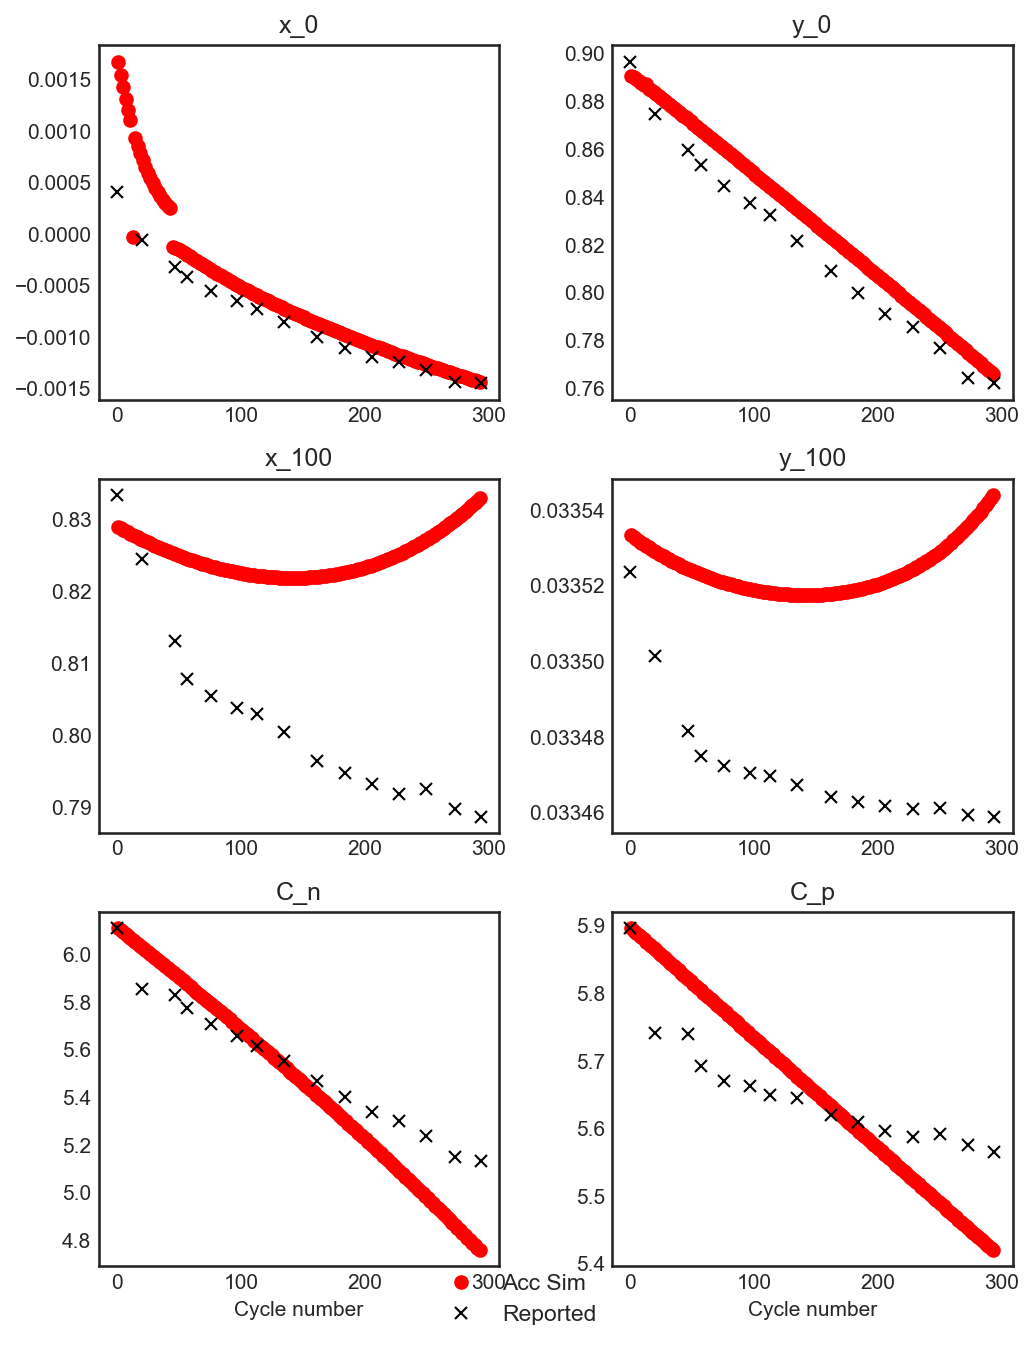

In [16]:
fig = plot(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

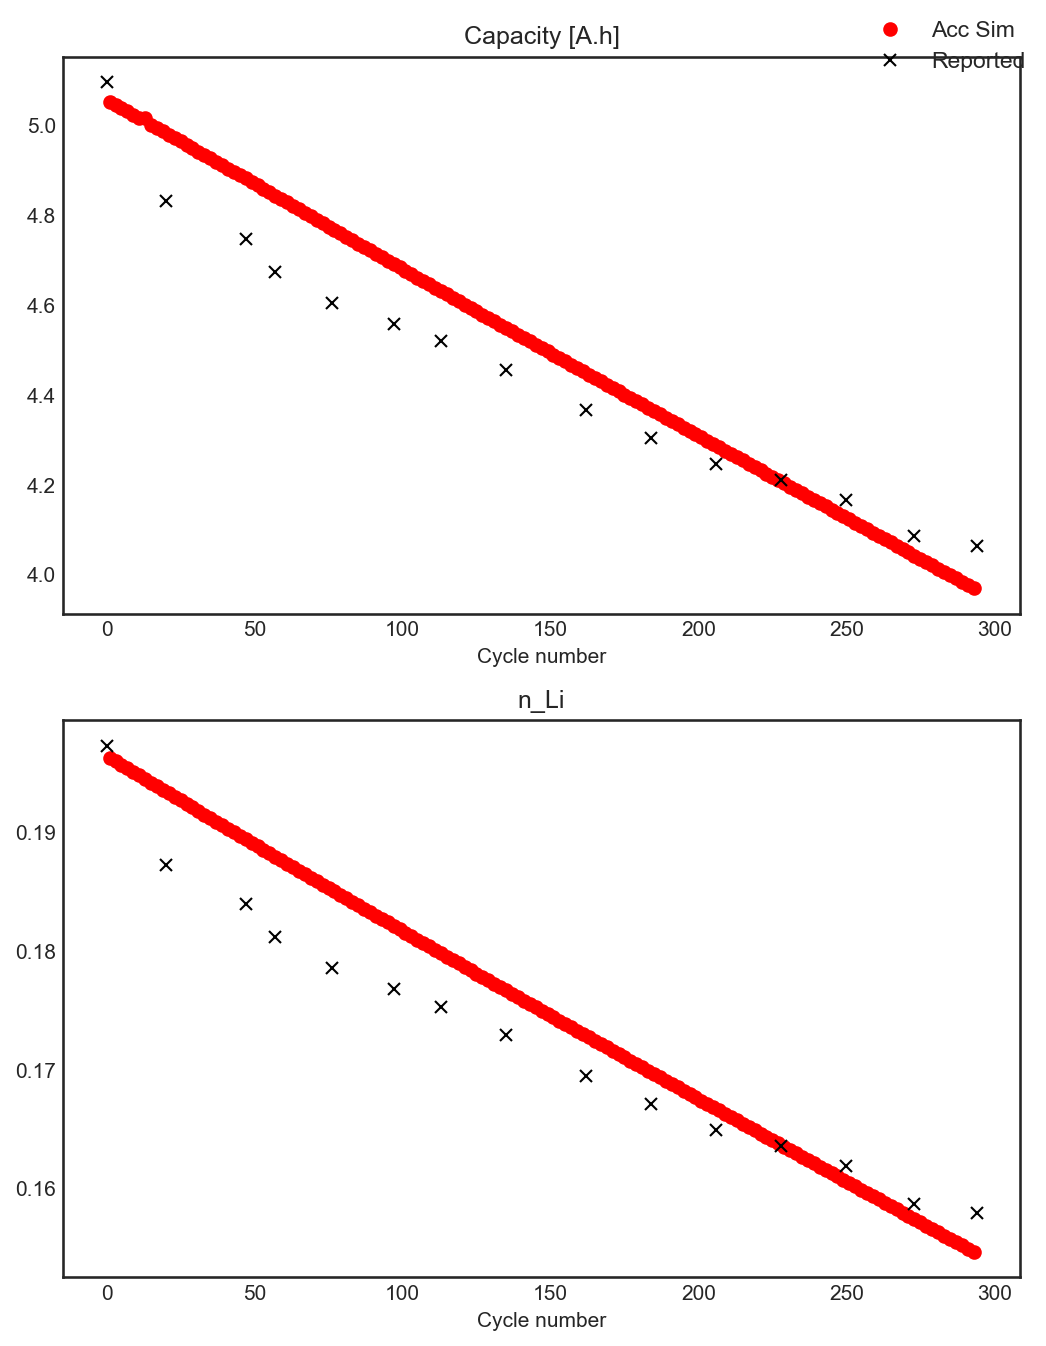

In [17]:
fig = plot1(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_cap_new.png')

In [18]:
pybamm.set_logging_level("NOTICE")
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Ambient temperature [K]": 273+25
    },
    check_already_exists=False,
)

In [19]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)

2022-02-24 15:28:01,690 - [NOTICE] simulation.solve(855): Cycle 1/294 (60.530 ms elapsed) --------------------
2022-02-24 15:28:01,691 - [NOTICE] simulation.solve(889): Cycle 1/294, step 1/4: Discharge at C/5 until 3V
2022-02-24 15:28:02,137 - [NOTICE] simulation.solve(889): Cycle 1/294, step 2/4: Rest for 5 min
2022-02-24 15:28:02,220 - [NOTICE] simulation.solve(889): Cycle 1/294, step 3/4: Charge at C/5 until 4.2V
2022-02-24 15:28:02,784 - [NOTICE] simulation.solve(889): Cycle 1/294, step 4/4: Hold at 4.2V until C/50
2022-02-24 15:28:03,620 - [NOTICE] simulation.solve(977): Capacity is now 5.050 Ah (originally 5.050 Ah, will stop at 2.525 Ah)
2022-02-24 15:28:03,621 - [NOTICE] simulation.solve(855): Cycle 2/294 (1.991 s elapsed) --------------------
2022-02-24 15:28:03,621 - [NOTICE] simulation.solve(889): Cycle 2/294, step 1/4: Discharge at C/5 until 3V
2022-02-24 15:28:04,090 - [NOTICE] simulation.solve(889): Cycle 2/294, step 2/4: Rest for 5 min
2022-02-24 15:28:04,108 - [NOTICE] 

In [20]:
long_sol_output =sol_long.summary_variables

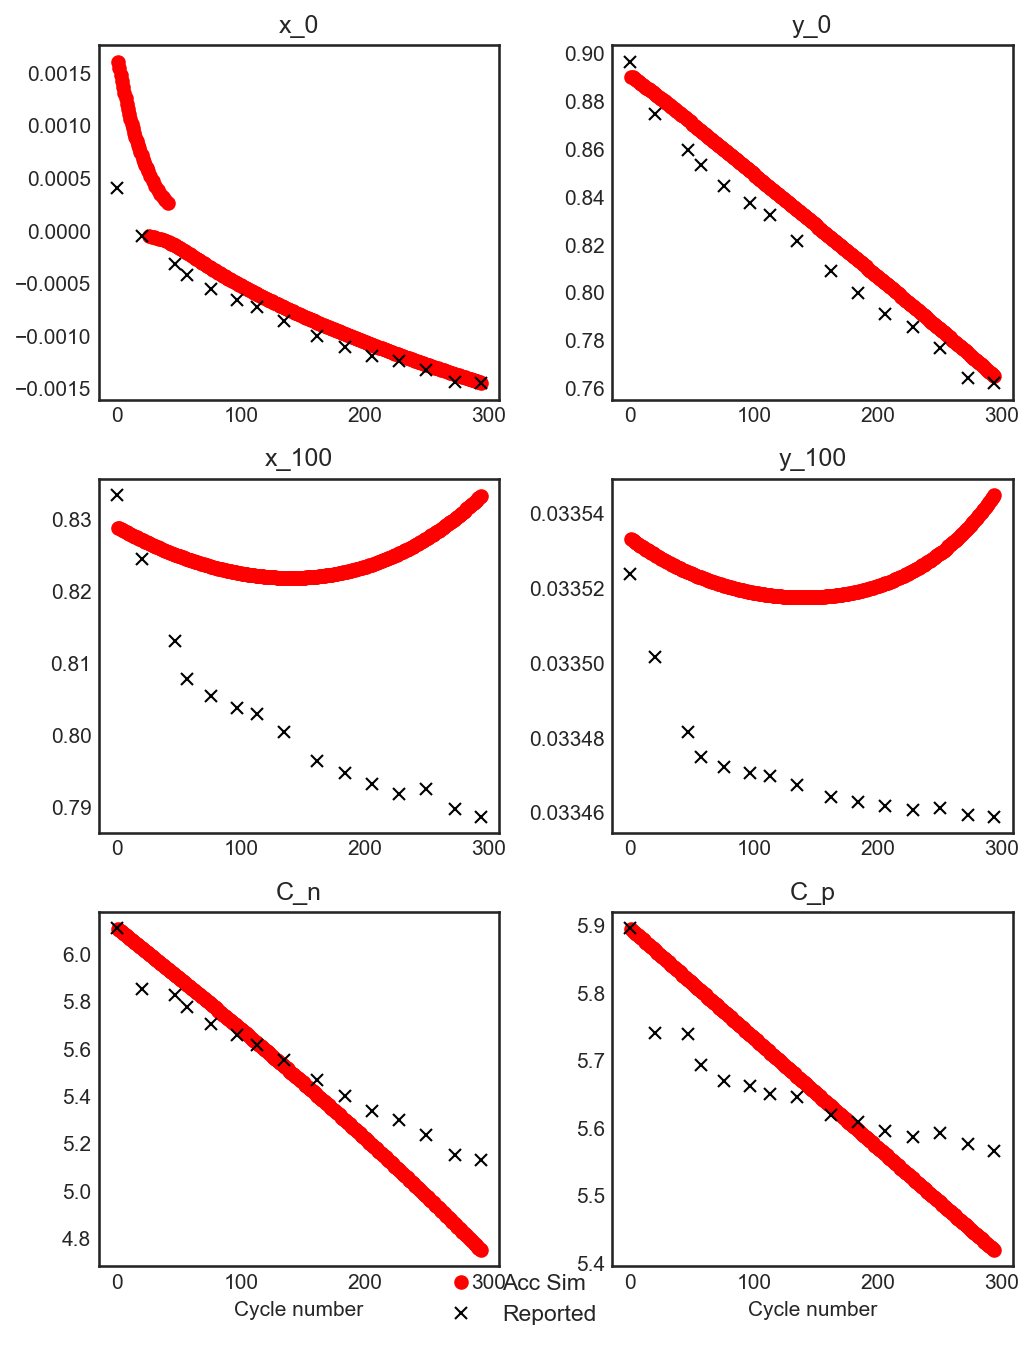

In [21]:
fig = plot(long_sol_output,dfe);

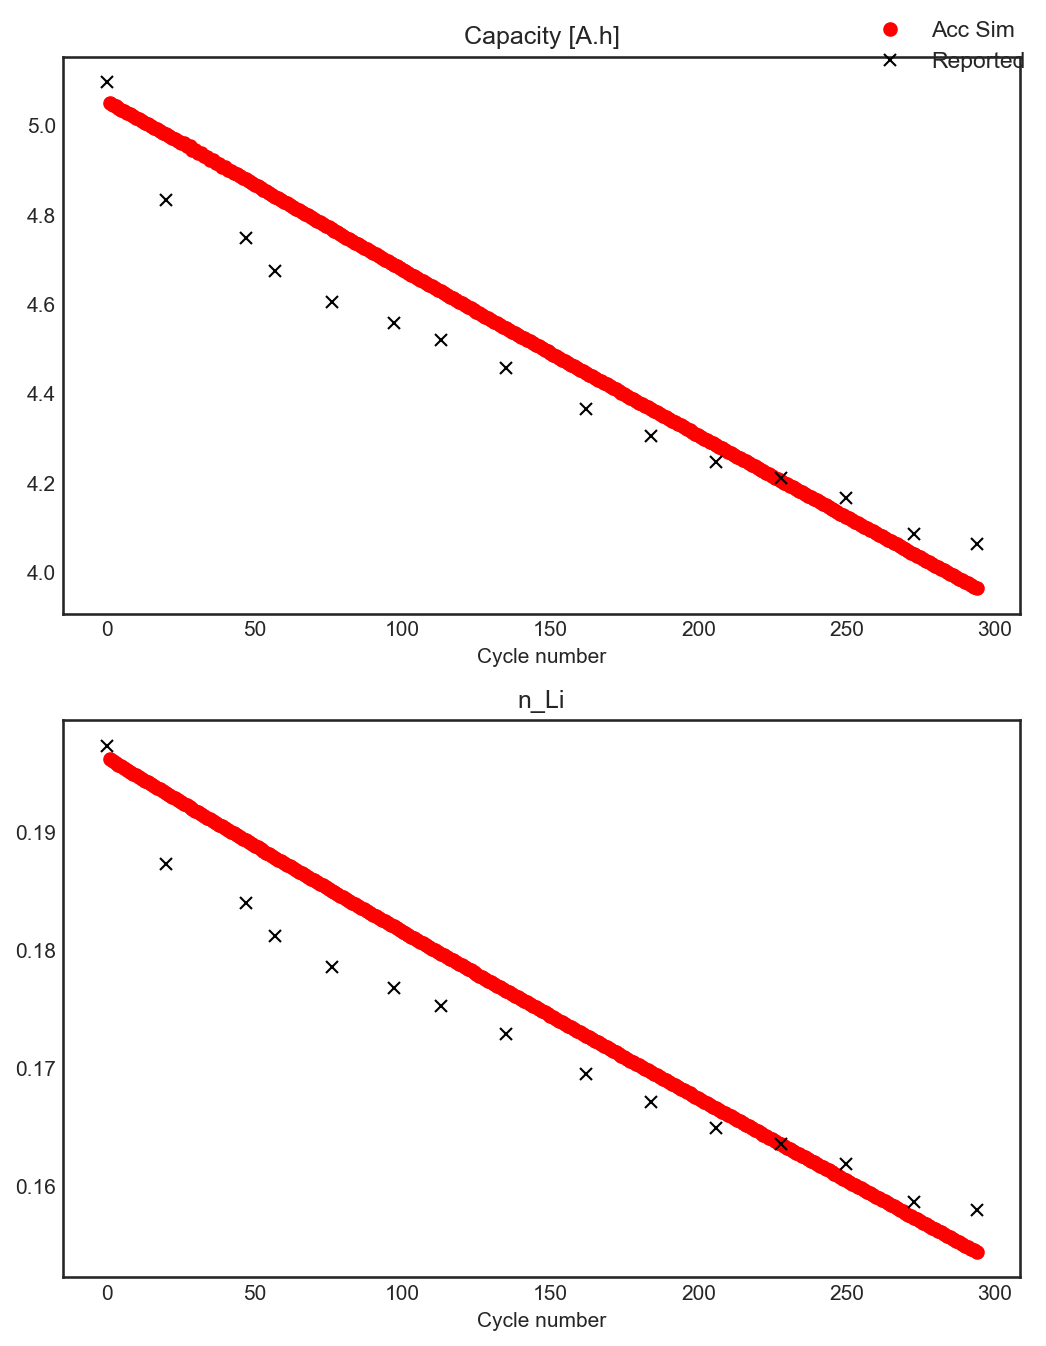

In [22]:
fig = plot1(long_sol_output,dfe);